In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import os

from ensemblecalibration.data.synthetic.binary_new import BinaryExperiment
from ensemblecalibration.meta_model import (
    CredalSetCalibrator,
    LinearCalibrator,
    DirichletCalibrator,
    TemperatureScalingCalibrator,
    MLPCalW,
)
from ensemblecalibration.losses.proper_losses import (
    GeneralizedBrierLoss,
    GeneralizedLogLoss,
)
from ensemblecalibration.data.dataset import MLPDataset
from ensemblecalibration.data.synthetic import create_synthetic_dataset
from ensemblecalibration.meta_model.train import train_model
from ensemblecalibration.utils.plot_functions import plot_ens_comb_cal
from ensemblecalibration.cal_estimates import (
    get_skce_ul,
    get_ece_kde,
    brier_obj,
    mmd_kce,
    get_kl_kde,
)
from ensemblecalibration.config import load_config

In [2]:
# losses to test
losses = {
    "brier": GeneralizedBrierLoss(),
    "log": GeneralizedLogLoss()
}
# metrics to test: 
metrics = {
    "skce": get_skce_ul,
    "ece": get_ece_kde,
    "brier": brier_obj,
    "mmd": mmd_kce,
    "kl": get_kl_kde
}
# recalibration methods
cal_methods = {
    "dirichlet": DirichletCalibrator,
    "temperature": TemperatureScalingCalibrator
}

### 1. Experiment: Gaussian Process Data


In [3]:
# load dictionary with configuration data:
config = load_config("../configs/gp_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]

In [4]:
# create datasets
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)
# train_set.indices


In [5]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

In [13]:
kl_kde = get_kl_kde(p_true_val, y_val, bw=0.001, )
kl_kde

tensor(0.0189, dtype=torch.float64, grad_fn=<MeanBackward0>)

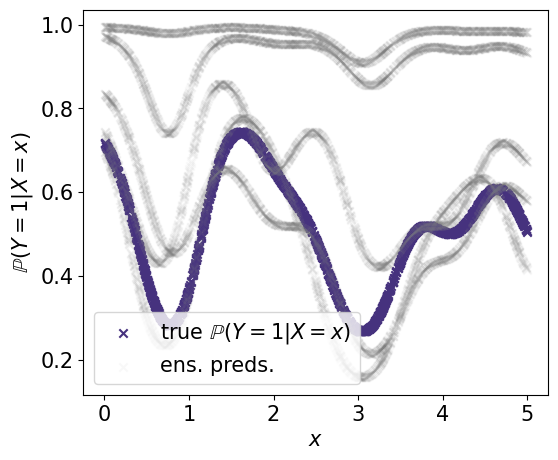

In [6]:
# plot data
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/gp/synthetic_data_gp_2.png", dpi=300)

In [7]:
# model = CredalSetCalibrator(comb_model=MLPCalW, cal_model=DirichletCalibrator, in_channels=1,
#                            n_classes=2,n_ensembles=3, hidden_dim=64, hidden_layers=3)

losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator]

# save scores in dict
scores_cal = {}
preds_cal = {}

losses_train = {}
losses_val = {}

for loss in losses:
    for train_mode in train_modes:
        for cal_model in cal_models:
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=16,
                hidden_layers=1,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=1000,
                lr=5e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=200,
                subepochs_cal=10,
                subepochs_comb=5
            )
            losses_train[(loss.__name__, train_mode, cal_model.__name__)] = loss_train
            losses_val[(loss.__name__, train_mode, cal_model.__name__)] = loss_val
            # save predictions for calibration
            outputs = model(x_val, p_pred_val)
            if len(outputs) == 3:
                p_cal, p_bar, weights = outputs
            elif len(outputs) == 2:
                p_cal, p_bar = outputs
                weights = None
            
            preds_cal[(loss.__name__, train_mode, cal_model.__name__)] = p_cal


            # if train_mode not in ["joint", "alternating"]:
            #     plot_ens_comb_cal(
            #         experiment=None,
            #         x_inst=x_val,
            #         p_true=p_true_val,
            #         ens_preds=p_pred_val,
            #         model=model,
            #         file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
            #         title=None,
            #         output_path="../../figures/gp/",
            #         alpha_comb=1.0,
            #         output_pbar="average"
            #     )
            # else:
            #     plot_ens_comb_cal(
            #         experiment=None,
            #         x_inst=x_val,
            #         p_true=p_true_val,
            #         ens_preds=p_pred_val,
            #         model=model,
            #         file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
            #         title=None,
            #         output_path="../../figures/gp/",
            #         alpha_comb=1.0,
            #         output_pbar="weighted"
            #     )
            # plt.show()

Epoch 1/1000: train=0.5659, val=0.5281
Epoch 10/1000: train=0.4732, val=0.5057
Epoch 20/1000: train=0.4714, val=0.5046
Epoch 30/1000: train=0.4703, val=0.5034
Epoch 40/1000: train=0.4699, val=0.5037
Epoch 50/1000: train=0.4695, val=0.5038
Epoch 60/1000: train=0.4694, val=0.5038
Epoch 70/1000: train=0.4692, val=0.5031
Epoch 80/1000: train=0.4690, val=0.5025
Epoch 90/1000: train=0.4687, val=0.5031
Epoch 100/1000: train=0.4685, val=0.5032
Epoch 110/1000: train=0.4681, val=0.5046
Epoch 120/1000: train=0.4679, val=0.5059
Epoch 130/1000: train=0.4675, val=0.5052
Epoch 140/1000: train=0.4674, val=0.5070
Epoch 150/1000: train=0.4671, val=0.5086
Epoch 160/1000: train=0.4670, val=0.5080
Epoch 170/1000: train=0.4669, val=0.5087
Epoch 180/1000: train=0.4668, val=0.5082
Epoch 190/1000: train=0.4666, val=0.5085
Epoch 200/1000: train=0.4664, val=0.5091
Early stopping at epoch 205
Best epoch: 5, Best val loss: 0.498871810734272
Stopped early at epoch 205
Epoch 1/1000: train=0.5335, val=0.5052
Epoch 10

KeyboardInterrupt: 

In [8]:
# filter preds_cal dicionary for 'brier loss' and 'DirichletCalibrator'
brier_dirichlet_preds = {k[1]: v for k, v in preds_cal.items() if k[0] == 'brier loss' and k[2] == 'DirichletCalibrator'}
brier_temperature_preds = {k[1]: v for k, v in preds_cal.items() if k[0] == 'brier loss' and k[2] == 'TemperatureScalingCalibrator'}
log_brier_preds = {k[1]: v for k, v in preds_cal.items() if k[0] == 'log loss' and k[2] == 'DirichletCalibrator'}
log_temperature_preds = {k[1]: v for k, v in preds_cal.items() if k[0] == 'log loss' and k[2] == 'TemperatureScalingCalibrator'}

list_preds = [brier_dirichlet_preds, brier_temperature_preds, log_brier_preds, log_temperature_preds]

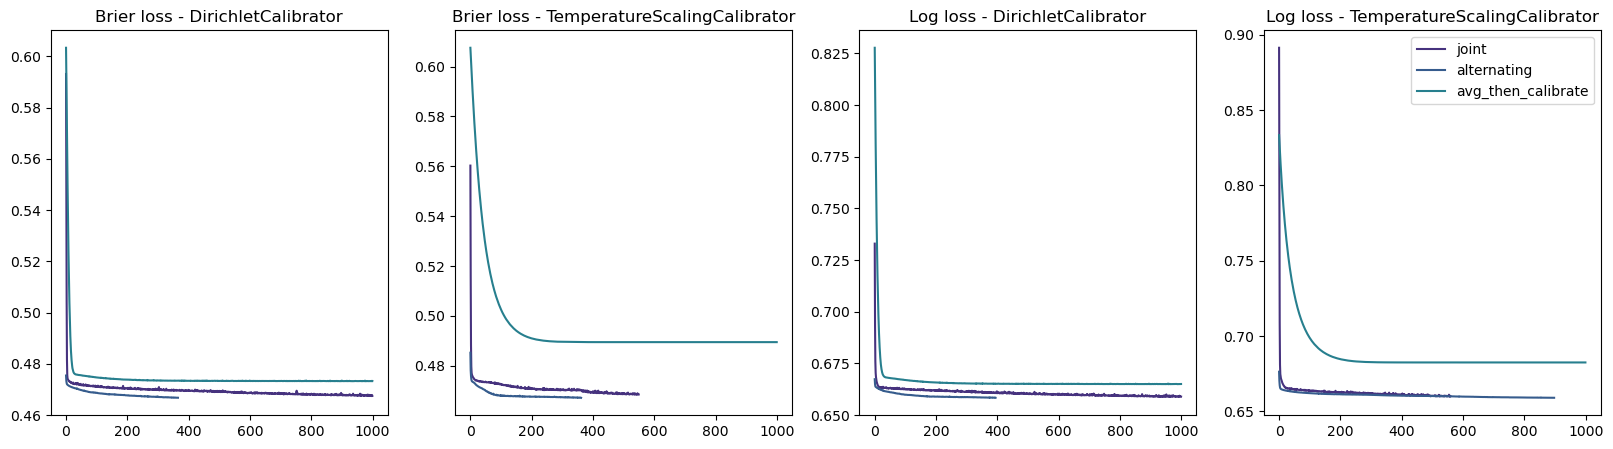

In [9]:
# plot losses for train and val 
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# filter out losses with 'brier' and 'DirichletCalibrator'
brier_dirichlet_train = {k[1]: v for k, v in losses_train.items() if k[0] == 'brier loss' and k[2] == 'DirichletCalibrator'}
brier_temperature_train = {k[1]: v for k, v in losses_train.items() if k[0] == 'brier loss' and k[2] == 'TemperatureScalingCalibrator'}
log_brier_train = {k[1]: v for k, v in losses_train.items() if k[0] == 'log loss' and k[2] == 'DirichletCalibrator'}
log_temperature_train = {k[1]: v for k, v in losses_train.items() if k[0] == 'log loss' and k[2] == 'TemperatureScalingCalibrator'}

# plot losses for train
ax[0].plot(brier_dirichlet_train['joint'], label='joint')
ax[0].plot(brier_dirichlet_train['alternating'], label='alternating')
ax[0].plot(brier_dirichlet_train['avg_then_calibrate'], label='avg_then_calibrate')
ax[0].set_title('Brier loss - DirichletCalibrator')

ax[1].plot(brier_temperature_train['joint'], label='joint')
ax[1].plot(brier_temperature_train['alternating'], label='alternating')
ax[1].plot(brier_temperature_train['avg_then_calibrate'], label='avg_then_calibrate')
ax[1].set_title('Brier loss - TemperatureScalingCalibrator')

ax[2].plot(log_brier_train['joint'], label='joint')
ax[2].plot(log_brier_train['alternating'], label='alternating')
ax[2].plot(log_brier_train['avg_then_calibrate'], label='avg_then_calibrate')
ax[2].set_title('Log loss - DirichletCalibrator')

ax[3].plot(log_temperature_train['joint'], label='joint')
ax[3].plot(log_temperature_train['alternating'], label='alternating')
ax[3].plot(log_temperature_train['avg_then_calibrate'], label='avg_then_calibrate')
ax[3].set_title('Log loss - TemperatureScalingCalibrator')

plt.legend()


{'joint': tensor([[0.5150, 0.4850],
        [0.5076, 0.4924],
        [0.4783, 0.5217],
        [0.5160, 0.4840],
        [0.4451, 0.5549],
        [0.5392, 0.4608],
        [0.4727, 0.5273],
        [0.3455, 0.6545],
        [0.5021, 0.4979],
        [0.7543, 0.2457],
        [0.6064, 0.3936],
        [0.5402, 0.4598],
        [0.5782, 0.4218],
        [0.7545, 0.2455],
        [0.5340, 0.4660],
        [0.4128, 0.5872],
        [0.5953, 0.4047],
        [0.5568, 0.4432],
        [0.7312, 0.2688],
        [0.5975, 0.4025],
        [0.3694, 0.6306],
        [0.4112, 0.5888],
        [0.5772, 0.4228],
        [0.7591, 0.2409],
        [0.5613, 0.4387],
        [0.7017, 0.2983],
        [0.7131, 0.2869],
        [0.6503, 0.3497],
        [0.4455, 0.5545],
        [0.3979, 0.6021],
        [0.4720, 0.5280],
        [0.3451, 0.6549],
        [0.7254, 0.2746],
        [0.4750, 0.5250],
        [0.4795, 0.5205],
        [0.7845, 0.2155],
        [0.5706, 0.4294],
        [0.4843, 0.5157],
  

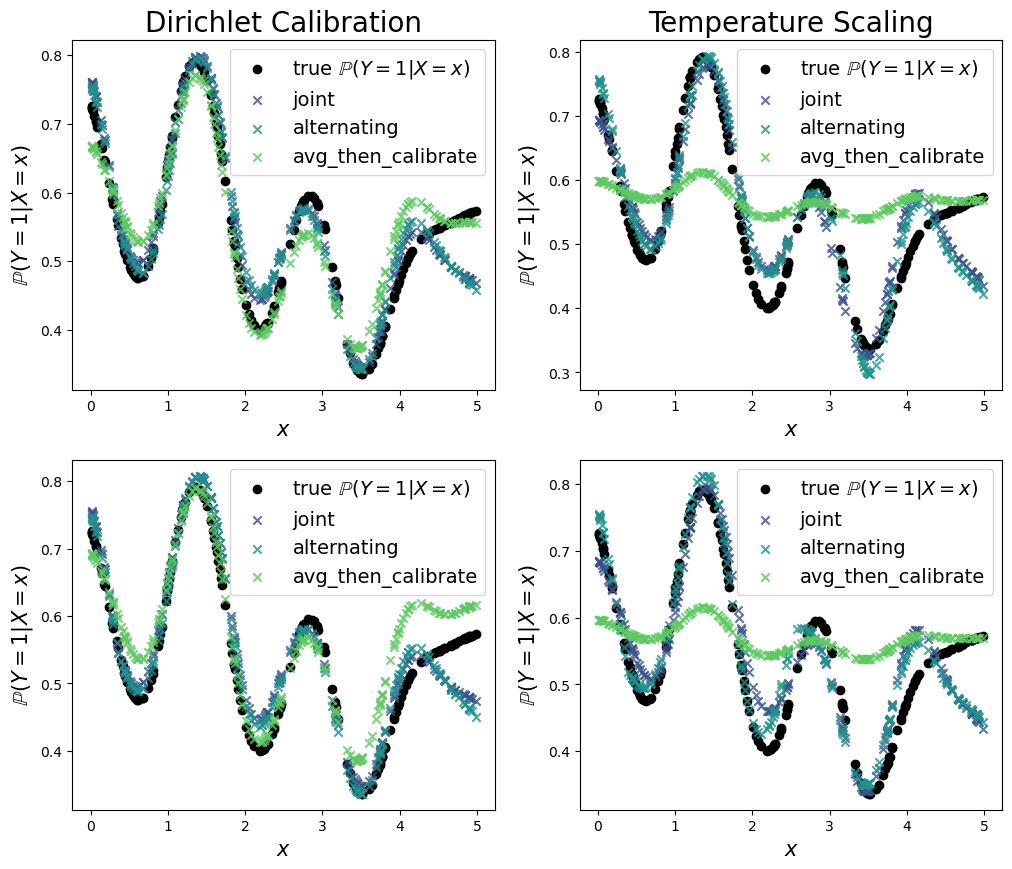

In [10]:
# plot calibrated, ensmeble and ground truth predictions
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

colors = sns.color_palette("viridis", 3)

for i, preds in enumerate(list_preds):
    print(preds)
    ax[i // 2, i % 2].scatter(
        x_val.squeeze(), p_true_val[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="o",
        color="black"
    )
    for j, (k, v) in enumerate(preds.items()):
        ax[i // 2, i % 2].scatter(
            x_val.squeeze(),
            v[:, 0].detach().numpy(),
            alpha=0.8,
            label=k,
            marker="x",
            color = colors[j]
        )
    ax[i // 2, i % 2].legend(fontsize=14)
    ax[i // 2, i % 2].set_xlabel(r"$x$", fontsize=15)
    ax[i // 2, i % 2].set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)

#set column titles: first: "Dirichlet Calibration, second: "Temperature Scaling"
for i in range(2):
    ax[0, i].set_title("Dirichlet Calibration" if i == 0 else "Temperature Scaling", fontsize=20)

plt.savefig("../../figures/gp/synthetic_data_gp_2_cal_preds.png", dpi=300)

### 2. Experiment

According to Vaicenavicious et al.

load config:

In [78]:
config = load_config("../configs/log_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]



split data:

In [79]:
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)


In [80]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

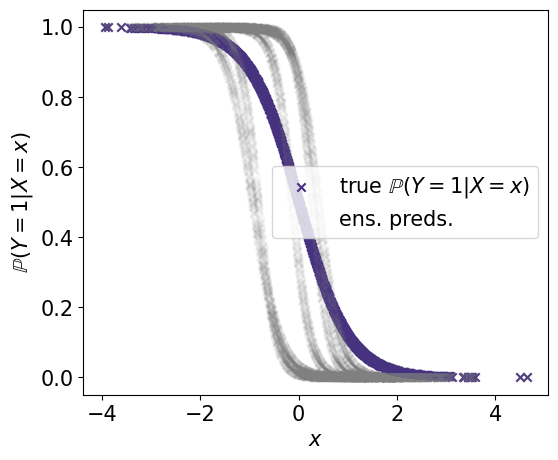

In [81]:
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/log/synthetic_data_log.png", dpi=300)

Epoch 1/500: train=0.2815, val=0.2835
Epoch 10/500: train=0.2338, val=0.2814
Epoch 20/500: train=0.2327, val=0.2842
Epoch 30/500: train=0.2326, val=0.2846
Epoch 40/500: train=0.2325, val=0.2846
Epoch 50/500: train=0.2325, val=0.2852
Early stopping at epoch 55
Best epoch: 5, Best val loss: 0.2761768251657486
Stopped early at epoch 55
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_DirichletCalibrator.png
Epoch 1/500: train=0.2760, val=0.2808
Epoch 10/500: train=0.2337, val=0.2832
Epoch 20/500: train=0.2329, val=0.2850
Epoch 30/500: train=0.2327, val=0.2853
Epoch 40/500: train=0.2326, val=0.2858
Epoch 50/500: train=0.2326, val=0.2857
Early stopping at epoch 54
Best epoch: 4, Best val loss: 0.275347463786602
Stopped early at epoch 54
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_TemperatureScalingCalibrator.png
Cycle 1/500: comb_loss=0.2767, cal_loss=0.2727, val=0.2820
Cycle 5/500: comb_loss=0.2446, cal_loss=0.2407, val=0.2764
Cycle 10/500: comb_los

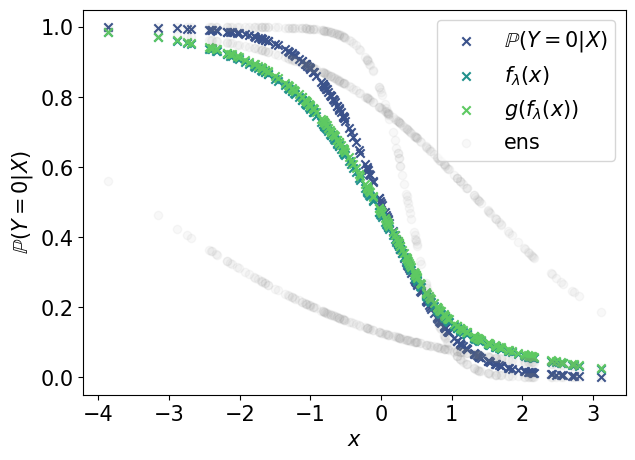

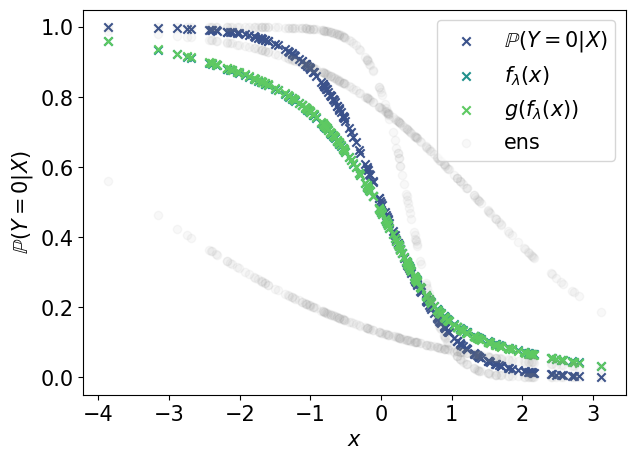

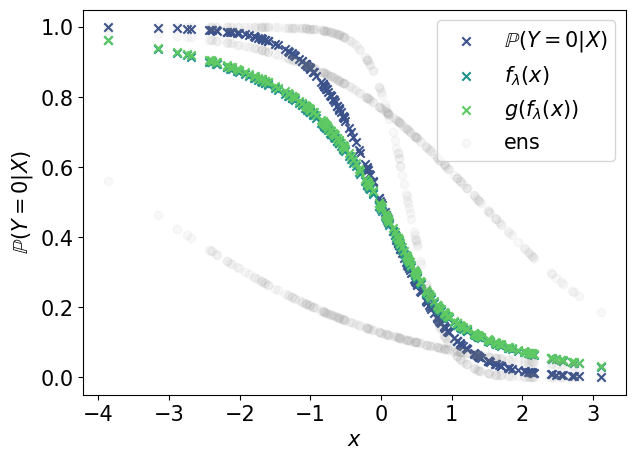

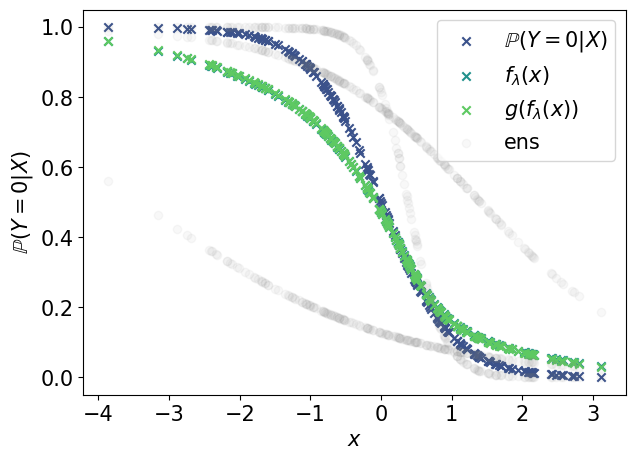

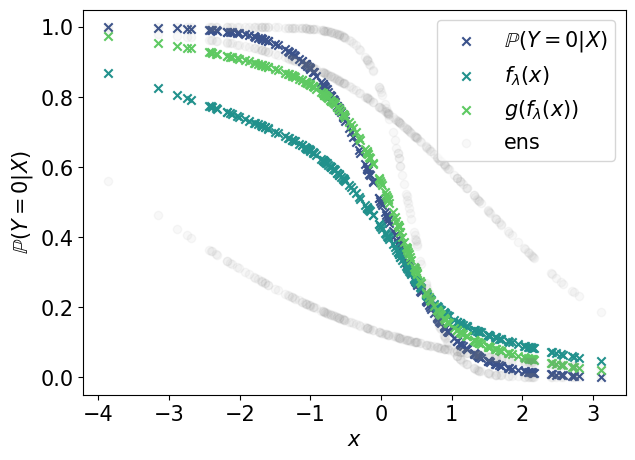

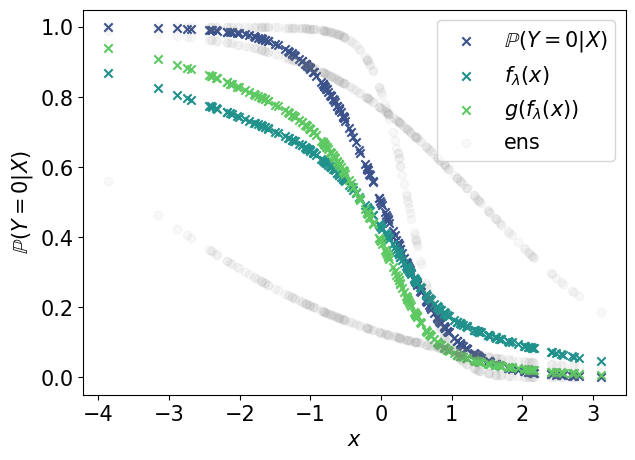

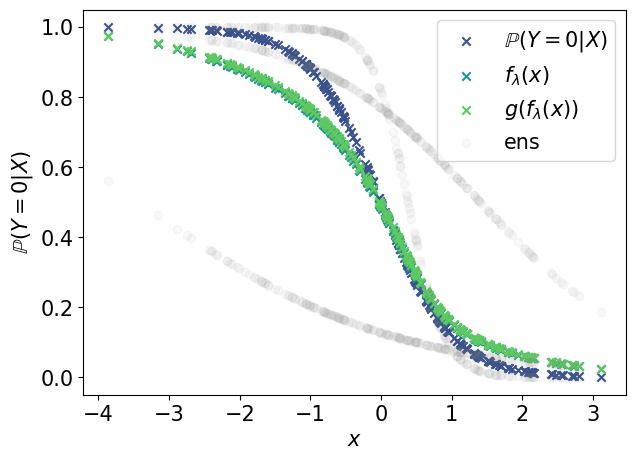

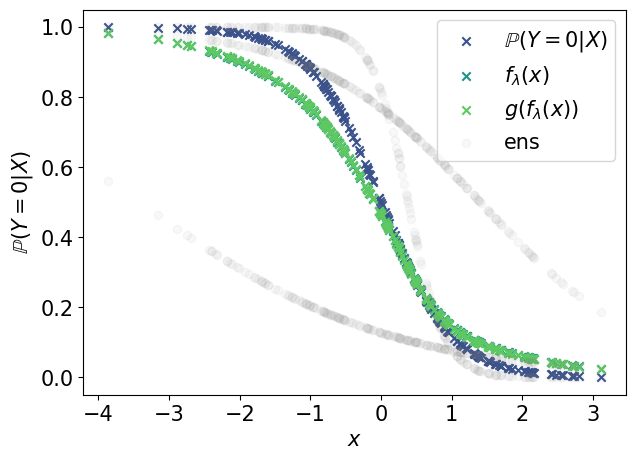

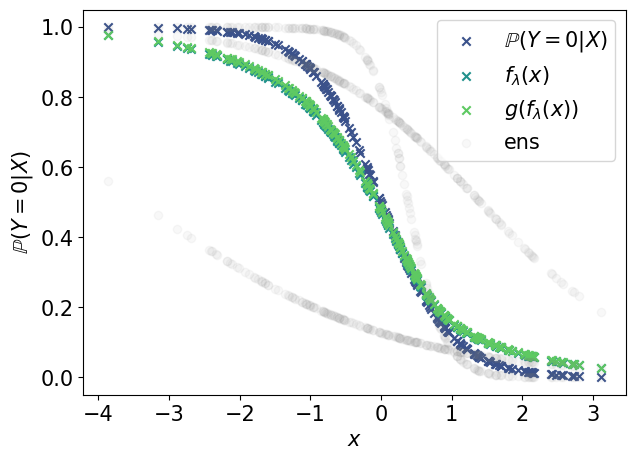

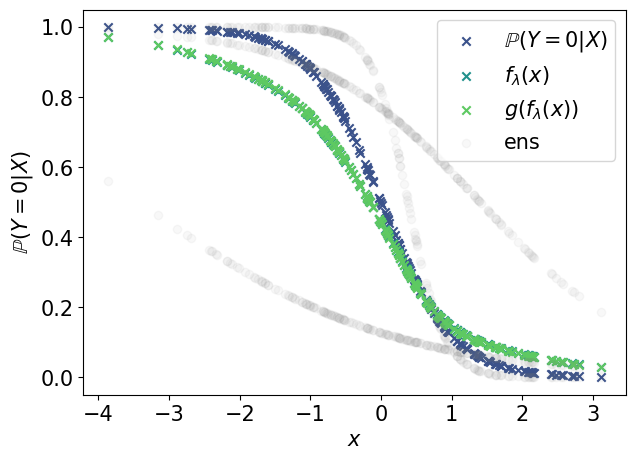

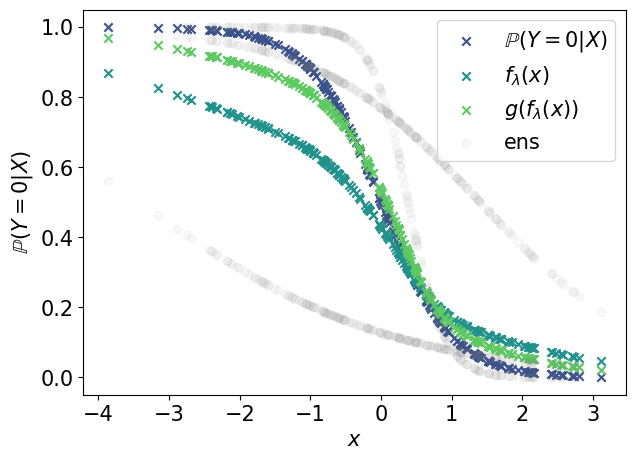

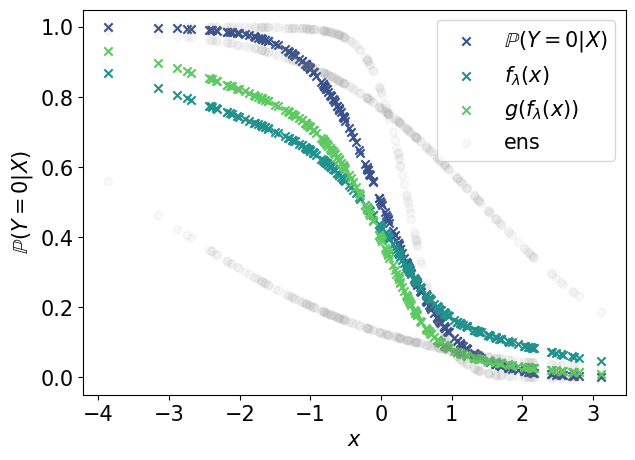

In [22]:
# train model
losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator]

# save scores in dict
scores_cal = {}

for loss_obj in losses:
    loss_name = loss_obj.__class__.__name__
    for train_mode in train_modes:
        for cal_model in cal_models:
            cal_model_name = cal_model.__name__
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=64,
                hidden_layers=2,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss_obj,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=500,
                lr=1e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=50,
            )
            if train_mode not in ["joint", "alternating"]:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="average",
                )
            else:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="weighted",
                )

            with torch.no_grad():
                if train_mode in ["joint", "alternating"]:
                    p_cal_val, p_bar_val, weights_l_val = model(x_val, p_pred_val)

                else:
                    # average first
                    p_bar_val = p_pred_val.mean(dim=1)
                    p_cal_val = model.cal_model(p_bar_val)

            p_cal_numpy = p_cal_val.detach().numpy()
            y_val_np = y_val.detach().numpy()

            # calculate scores
            skce_val = get_skce_ul(
                p_bar=p_cal_val, y=y_val, bw=config["dict_skce"]["bw"]
            )
            ece_kde_val = get_ece_kde(
                p_bar=p_cal_val,
                y=y_val,
                p=config["dict_kde_ece"]["p"],
                bw=config["dict_kde_ece"]["bw"],
            )
            brier_val = brier_obj(p_bar=p_cal_val, y=y_val, params={})
            mmd_val = mmd_kce(p_bar=p_cal_val, y=y_val, bw=config["dict_mmd"]["bw"])

            skce_val = (
                float(torch.abs(skce_val))
                if isinstance(skce_val, torch.Tensor)
                else abs(skce_val)
            )
            ece_kde_val = (
                float(torch.abs(ece_kde_val))
                if isinstance(ece_kde_val, torch.Tensor)
                else abs(ece_kde_val)
            )
            brier_val = (
                float(torch.abs(brier_val))
                if isinstance(brier_val, torch.Tensor)
                else abs(brier_val)
            )
            mmd_val = (
                float(torch.abs(mmd_val))
                if isinstance(mmd_val, torch.Tensor)
                else abs(mmd_val)
            )

            key = (loss_name, train_mode, cal_model_name)
            scores_cal[key] = {
                "skce": skce_val,
                "ece_kde": ece_kde_val,
                "brier": brier_val,
                "mmd": mmd_val,
            }

In [29]:
def save_metric_pivoted(
    scores_cal: dict,
    metric_name: str,
    csv_path: str,
    train_modes=("joint", "alternating", "avg_then_calibrate")
):
    """
    Saves one metric (e.g. 'brier', 'mmd') in a pivoted table:
      - Rows: (loss, calibrator) pairs
      - Columns: each train_mode in train_modes

    scores_cal is a dict like:
      {
        (loss_name, train_mode, cal_model_name): {
            'skce': float,
            'ece_kde': float,
            'brier': float,
            'mmd': float
        },
        ...
      }

    metric_name: the key in the inner dict (e.g. 'brier', 'mmd', 'skce', etc.)
    csv_path: path to write the CSV. We'll ensure the directory exists.
    train_modes: a tuple of column names for the methods.

    The resulting CSV columns are:
      ['(loss,calibrator)', 'joint', 'alternating', 'avg_then_calibrate']
    or some variation, depending on train_modes.
    """
    # 1) Make sure the output directory exists
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # 2) Gather unique (loss_name, cal_model_name) from the dict
    row_keys = set()
    for (loss_name, tm, cal_model_name) in scores_cal.keys():
        row_keys.add((loss_name, cal_model_name))

    # Convert to a sorted list if you prefer sorted rows
    row_keys = sorted(row_keys)

    # 3) We'll build a dict: pivoted_rows[(loss,cal)] = {tm: metric_value, ...}
    pivoted_rows = {}
    for (loss_name, cal_model_name) in row_keys:
        pivoted_rows[(loss_name, cal_model_name)] = {}

    for (loss_name, tm, cal_model_name), metric_dict in scores_cal.items():
        # e.g. metric_dict might have {"brier": 0.1, "mmd":0.05, ...}
        val = metric_dict.get(metric_name, None)
        if val is not None:
            # store in pivoted structure
            pivoted_rows[(loss_name, cal_model_name)][tm] = val

    # 4) Now write to CSV
    #   columns = ["(loss,calibrator)", "joint", "alternating", "avg_then_calibrate", ...]
    columns = ["(loss,cal)"] + list(train_modes)

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        # header row
        writer.writerow(columns)

        # each row = (loss, cal), then the metric for each train_mode
        for (loss_name, cal_model_name) in row_keys:
            row_label = f"({loss_name},{cal_model_name})"
            row_values = [pivoted_rows[(loss_name, cal_model_name)].get(tm, "")
                          for tm in train_modes]
            row = [row_label] + row_values
            writer.writerow(row)

    print(f"Saved pivoted {metric_name} scores to {csv_path}")


In [33]:
save_metric_pivoted(scores_cal, metric_name="brier", csv_path="../results/log/brier_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="skce", csv_path="../results/log/skce_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="ece_kde", csv_path="../results/log/ece_kde_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="mmd", csv_path="../results/log/mmd_scores_log_synthetic.csv")

Saved pivoted brier scores to ../results/log/brier_scores_log_synthetic.csv
Saved pivoted skce scores to ../results/log/skce_scores_log_synthetic.csv
Saved pivoted ece_kde scores to ../results/log/ece_kde_scores_log_synthetic.csv
Saved pivoted mmd scores to ../results/log/mmd_scores_log_synthetic.csv
